## Introduction to Generating Steric Parameters with DBSTEP
In this Notebook we are going to load a dataset of molecules, complexes of Ni(CO)3 with different N-heterocyclic carbene ligands. We have a pre-computed property, which is the dissociation energy required to remove a molecule of CO.

The steric demand of the ligand is thought to play an important role. We therefore set out to obtain parameters that describe these differential steric effects using DBSTEP (https://github.com/patonlab/DBSTEP)

In [1]:
# if not already installed in your environment
%pip install cclib
#%pip install dbstep
%pip install xyz-py
%pip install tqdm
%pip install scikit-learn
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from xyz_py import load_xyz 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import r2_score
import numpy as np

# import DBSTEP for steric parameters
import dbstep.Dbstep as db  

In [3]:
# read in a CSV - in this case there are three columns
data = pd.read_csv('carbene_data.csv')
data.head() # shows first 5 lines

,ligand,enthalpy,TEP
0,L1,21.70,2059.99
1,L2,19.12,2063.87
2,L3,20.23,2066.15
3,L4,19.78,2058.72
4,L5,13.90,2082.59


In [4]:
# the structures come from Organometallics 2009, 28, 6458–6461 DOI: 10.1021/om900654g
ligands = data.ligand
xyz_files = ['carbenes/'+ligand+'.xyz' for ligand in ligands]

In [35]:
# by default, buried volumes use a sphere of radius 3.5 Angstrom. How about we try several values?
# lets turn this into a function
def get_buried_volumes(xyz_files, radius=3.5):
    v_bur = [] 
    shell_bur = []
    
    print('o  Vbur for radius {:5.2f} ...'.format(radius))
    
    for file in tqdm(xyz_files):
        # the center of the sphere will be defined at Nickel    
        atoms, coords = load_xyz(file)
        center = atoms.index('Ni') + 1
        
        # by convention we don't include the Ni(CO)3 atoms
        non_nhc_atoms = '1,2,3,4,5,6,7'
    
        #Create DBSTEP object
        mol = db.dbstep(file, atom1=center, exclude=non_nhc_atoms, commandline=True, verbose=False, volume=True, quiet=True, r=radius, vshell=0.5)  
        
        # append the object property "bur_vol" to the list v_bur
        v_bur.append(mol.bur_vol)
        shell_bur.append(mol.bur_shell)
        
    return v_bur, shell_bur

In [36]:
# Add to the dataframe as new columns
data['v_bur_1.5'], data['s_bur_1.5'] = get_buried_volumes(xyz_files, 1.5)
data['v_bur_2.0'], data['s_bur_2.0'] = get_buried_volumes(xyz_files, 2.0)
data['v_bur_2.5'], data['s_bur_2.5'] = get_buried_volumes(xyz_files, 2.5)
data['v_bur_3.0'], data['s_bur_3.0'] = get_buried_volumes(xyz_files, 3.0)
data['v_bur_3.5'], data['s_bur_3.5'] = get_buried_volumes(xyz_files, 3.5)
data['v_bur_4.0'], data['s_bur_4.0'] = get_buried_volumes(xyz_files, 4.0)

o  Vbur for radius  1.50 ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 13.48it/s]


o  Vbur for radius  2.00 ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 12.86it/s]


o  Vbur for radius  2.50 ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 11.83it/s]


o  Vbur for radius  3.00 ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:02<00:00, 10.64it/s]


o  Vbur for radius  3.50 ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:02<00:00,  9.23it/s]


o  Vbur for radius  4.00 ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:02<00:00,  7.71it/s]


In [37]:
data.head() # we have added several new columns - V_bur and S_bur evaluated with different radii!
data.to_csv('out2.csv')

In [31]:
r2_values = [np.corrcoef(data['enthalpy'], v_burs)[0,1] ** 2 for v_burs in [data['v_bur_1.5'], data['v_bur_2.0'], data['v_bur_2.5'], data['v_bur_3.0'], data['v_bur_3.5'], data['v_bur_4.0']]]
print(', '.join(f'{q:.3f}' for q in r2_values))

0.433, 0.676, 0.878, 0.823, 0.768, 0.739


In [32]:
r2_values = [np.corrcoef(data['enthalpy'], s_burs)[0,1] ** 2 for s_burs in [data['s_bur_1.5'], data['s_bur_2.0'], data['s_bur_2.5'], data['s_bur_3.0'], data['s_bur_3.5'], data['s_bur_4.0']]]
print(', '.join(f'{q:.3f}' for q in r2_values))

0.367, 0.881, 0.790, 0.703, 0.666, 0.698


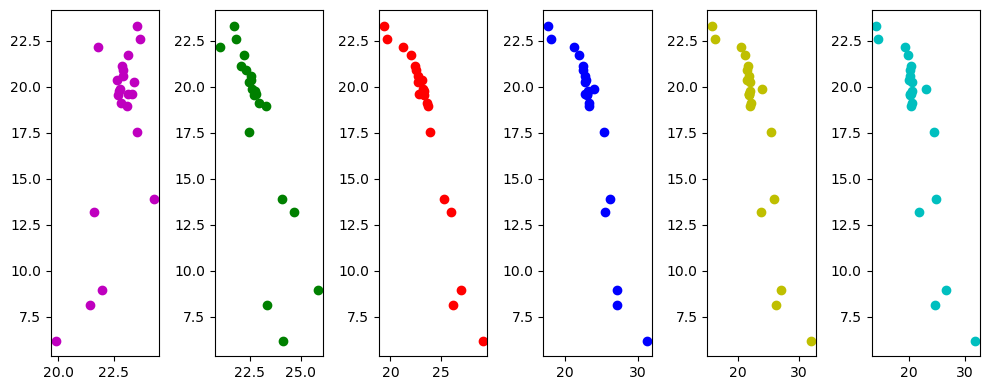

In [33]:
# Multiple plots

fig=plt.figure(figsize=(10, 4))

ax = plt.subplot(1,6,1)
plt.scatter(data['v_bur_1.5'], data['enthalpy'], color='m')

ax = plt.subplot(1,6,2)
plt.scatter(data['v_bur_2.0'], data['enthalpy'], color='g')

ax = plt.subplot(1,6,3)
plt.scatter(data['v_bur_2.5'], data['enthalpy'], color='r')

ax = plt.subplot(1,6,4)
plt.scatter(data['v_bur_3.0'], data['enthalpy'], color='b')

ax = plt.subplot(1,6,5)
plt.scatter(data['v_bur_3.5'], data['enthalpy'], color='y')

ax = plt.subplot(1,6,6)
plt.scatter(data['v_bur_4.0'], data['enthalpy'], color='c')

plt.tight_layout()
plt.show()